In [1]:
import simpy
import numpy as np
import statistics
import matplotlib.pyplot as plt

In [2]:
np.random.seed(12345)

In [3]:
"""
Used sources: 
- https://stackoverflow.com/questions/73384766/simple-m-m-1-queuing-simulation-with-simpy-departure-placement-issue
- https://simpy.readthedocs.io/en/latest/examples/bank_renege.html
- https://www.youtube.com/watch?v=eSNfC-HOl44
"""

'\nUsed sources: \n- https://stackoverflow.com/questions/73384766/simple-m-m-1-queuing-simulation-with-simpy-departure-placement-issue\n- https://simpy.readthedocs.io/en/latest/examples/bank_renege.html\n- https://www.youtube.com/watch?v=eSNfC-HOl44\n'

In [4]:
def generate_inter_arrival_time(labda):
    return np.random.exponential(labda)

def generate_service_time(mu):
    return np.random.exponential(mu)

observation_times = []
queue_lengths = []
server_lengths = []
def observe(env, servers, measurement_time_interval):
    """
    Takes the environment and servers as arguments in order to refer to the right server

    Uses two lists in order to plot meaningful results. 
    One is used to append the current timestep
    The other is used to state the length of the queue
    """
    i = 0
    while True:
        # current time
        observation_times.append(env.now)
        # current queue length
        queue_lengths.append(len(servers.queue))
        # current server processing length (either 0 or 1)
        server_lengths.append((len(servers.users)))

        # make an observation every 1 timestep
        yield env.timeout(measurement_time_interval)

def generator(env, servers, mean_arrivals, mean_served):
    """
    In case of a cafe or shop, this simulates the entire environment i.e. the shop.
    """
    # set i in order to be able to identify customers
    i = 0 

    while True:
        i+=1
        service_time = generate_service_time(mean_arrivals)
        yield env.timeout(generate_inter_arrival_time(mean_served))
        env.process(customer(env, i, service_time, servers))

waiting_times = []
service_times = []
current_times = []
def customer(env, customer, service_time, servers):
    """
    Processes a customer

    First argument is the environment that it will be operating in
    second argument is the server, so that the customer generator knows what are
    the servers that it have access to
    """
    # with priority, choses the lowest service time
    with servers.request(priority=service_time) as request:
        # Customer arrives
        arrival_time = env.now
        current_times.append(env.now)
        # customer gets serviced
        # print(f"At time: {env.now: .2f} | customer {customer} joins queue with service time {service_time:.2f}")
        yield request # request and wait until server is free
        # customer has been serviced 
        # print(f"At time: {env.now: .2f} | customer {customer} is being served with service time {service_time:.2f}")
        service_times.append(service_time)
        yield env.timeout(service_time) # service takes time labda
        # departs
        # print(f"At time: {env.now: .2f} | customer {customer} departs with service time {service_time:.2f}")
        departure_time = env.now
        waiting_times.append(departure_time - arrival_time)

# intuition for yield: pause function until this event happens

In [5]:
"""
Run a simulation
"""

# set parameters
labda = 4 # average number of arrivals per time period
mu = 6 # average number of customers served per time period

labda_mu_combinations = [(1,4),(2,4),(3,4)]
number_of_simulations = 250
measurement_time_interval = 5
simulation_time = 100

q_lengths_matrices = []
c = []
average_service_times_list = []
average_total_times_list = [] 
average_waiting_times_list = []


for labda, mu in labda_mu_combinations:
    # to observe over all runs
    average_total_times = []
    average_q_lengths = []
    average_total_in_systems = []
    average_waiting_times = []
    average_service_times = []
    dimension = int(simulation_time/measurement_time_interval)
    q_lengths_matrix = np.empty((0, dimension))

    mean_arrivals = 1/labda # mean inter-arrival time
    mean_served = 1/mu # time to serve one customer
    
    for i in range(number_of_simulations):  
        # to observe in a sigle run
        observation_times = []
        queue_lengths = []
        server_lengths = []
        waiting_times = []
        service_times = []

        # initialize environment
        env = simpy.Environment()
        servers = simpy.PriorityResource(env, capacity=1)
        env.process(generator(env, servers, mean_arrivals, mean_served))
        env.process(observe(env, servers, measurement_time_interval))
        env.run(until=simulation_time)

        
        total_in_system = np.array(queue_lengths) + np.array(server_lengths)
        q_lengths_matrix = np.vstack([q_lengths_matrix, total_in_system])

        # keep track of statistics
        average_waiting_time = statistics.mean(waiting_times)
        average_service_time = statistics.mean(service_times)
        average_waiting_times.append(average_waiting_time)
        average_service_times.append(average_service_time)
        average_total_times.append(average_waiting_time + average_service_time)


    
    q_lengths_matrices.append(q_lengths_matrix)
    average_service_times_list.append(average_service_times)
    average_waiting_times_list.append(average_waiting_times)
    average_total_times_list.append(average_total_times)





(0.0, 160.0)

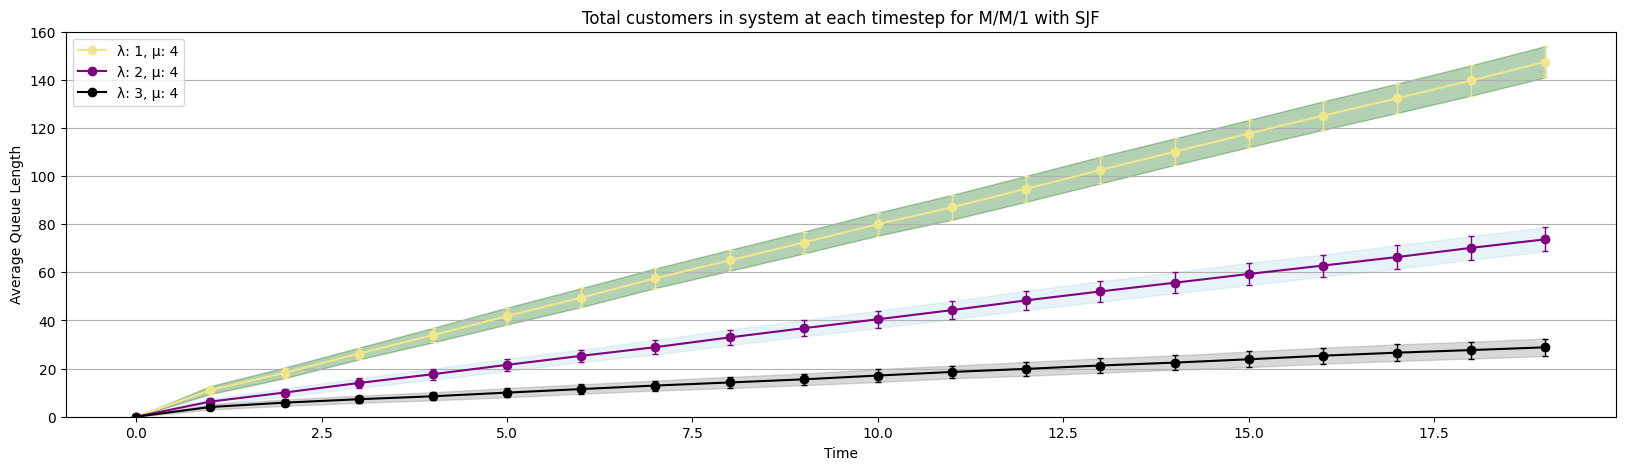

In [6]:
"""
Plot Total customers in system at each timestep

Todo: 95% c int
"""
color_combinations = [("khaki", "darkgreen"), ("purple", "lightblue"),("black","gray")]

plt.figure(figsize=(20, 5))
for i, matrix in enumerate(q_lengths_matrices):
    line, sd = color_combinations[i]
    labda, mu = labda_mu_combinations[i]
    column_means = np.mean(matrix, axis=0)
    column_std_devs = np.std(matrix, axis=0)

    # 95% confidence interval
    z_score = 1.96  
    margin_of_error = z_score * (column_std_devs / np.sqrt(dimension))
    lower_bounds = column_means - margin_of_error
    upper_bounds = column_means + margin_of_error

    x_axis = range(dimension)
    plt.plot(x_axis, column_means, marker="o", color=line, label=f"λ: {labda}, μ: {mu}")
    plt.fill_between(x_axis, column_means - margin_of_error, column_means + margin_of_error, 
                 color=sd, alpha=0.3)
    plt.errorbar(x_axis, column_means, yerr=margin_of_error, fmt="s", color=line, capsize=2, markersize=4, elinewidth=1)
    
plt.xlabel("Time")
plt.ylabel("Average Queue Length")
plt.title("Total customers in system at each timestep for M/M/1 with SJF")
plt.legend()
plt.grid(axis="y")
plt.ylim(0,160)

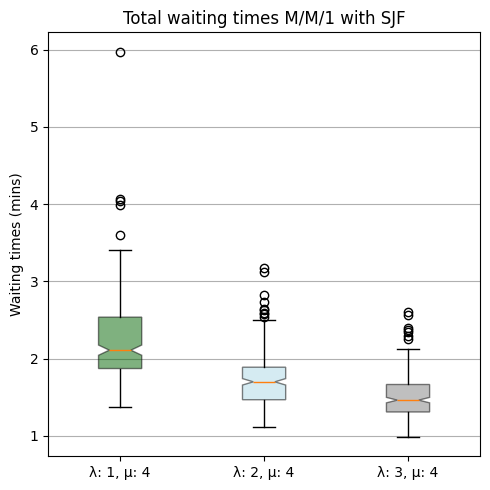

In [9]:

all_data = average_waiting_times_list
colors = ['darkgreen', 'lightblue', 'gray']

labels = []
for labda, mu in labda_mu_combinations:
    labels += [f"λ: {labda}, μ: {mu}"]

boxprops = dict(patch_artist=True, notch=True)
plt.figure(figsize=(5, 5))
bp = plt.boxplot(average_waiting_times_list, labels=labels, **boxprops)

for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.5)

plt.title("Total waiting times M/M/1 with SJF")
plt.ylabel("Waiting times (mins)")
plt.grid(axis="y")

plt.tight_layout()

In [8]:
"""
Ttests to do
"""



'\nTtests to do\n'